## Access Autonomous Underwater Vehicle data in Parquet
A jupyter notebook to show how to access and plot the AODN autonomous_underwater_vehicle dataset available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/af5d0ff9-bb9c-4b7c-a63c-854a630b6984).

In [1]:
dataset_name = "autonomous_underwater_vehicle"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os


def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    import xarray as xr
    xr.set_options(display_style='text')
    os.system('uv pip install --system -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')
else:
    os.system('uv venv')
    os.system('uv pip install -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 436ms


In [3]:
import requests
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, \
    get_temporal_extent, get_schema_metadata, plot_ts_diagram
import pyarrow.parquet as pq
import pyarrow.dataset as pds

import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

campaign_name: string
dive_name: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'campaign_name')
print(list(unique_partition_value))  # showing a subset only

['Tasmania202001', 'Tasmania202104', 'GBR200709', 'Ningaloo201203', 'Ningaloo201904', 'GBR201107', 'ScottReef201108', 'CoralSea202008', 'Wollongong202201', 'PS201012', 'Tasmania201306', 'SEQueensland201907', 'ScottReef201503', 'SolitaryIs201208', 'WA_SW_202103', 'Tasmania201406', 'WA202205', 'SEQueensland201010', 'SEQueensland201310', 'Wilsonsprom201603SS', 'PS201211', 'WA201304', 'PS201502', 'Tasmania201106', 'GBR201312', 'Sydney201211', 'Tasmania202302', 'SouthAustralia202012', 'Tasmania202208', 'Batemans201211', 'WA202303', 'Batemans201411', 'Tasmania201502', 'SouthAustraliaGAB202204', 'Tasmania200903', 'SEQueensland201510', 'EMR202001', 'GBR201212', 'Tasmania201808', 'DiscoveryBay202112', 'SEQueensland201010Eng', 'WA201004', 'SAJosephBanks200806', 'WA202103', 'GBR201509', 'Apollo202309', 'Tasmania200906', 'GBR201102', 'TasVic201602SS', 'SEQueensland201210', 'Tasmania201610', 'Sydney201303', 'WA201204', 'SEQueensland201111', 'Sydney202111', 'WA201104', 'SouthAustralia201805', 'WA201

## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:486: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:486: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


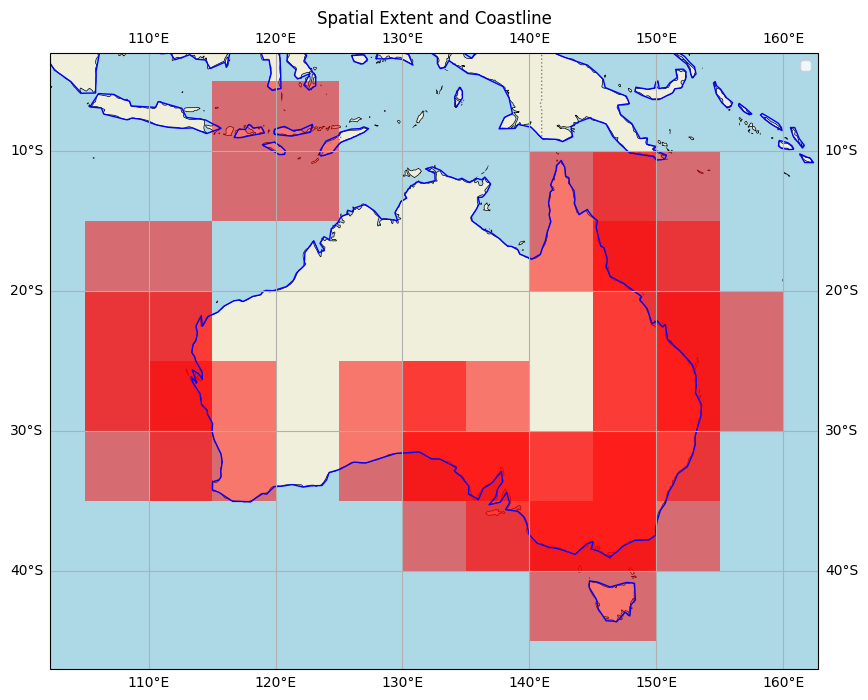

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [9]:
get_temporal_extent(parquet_ds)

(Timestamp('2007-09-28 01:40:25.568000'),
 Timestamp('2023-10-11 02:09:54.375719936'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'timestamp': {'type': 'int64'},
 'polygon': {'type': 'string'},
 'filename': {'type': 'string'},
 'campaign_name': {'type': 'string'},
 'dive_name': {'type': 'string'},
 'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0,
  'valid_max': 90000.0,
  'comments': 'Time synchronised before diving. There after standard PC clock',
  'quality_control_set': 1,
  'quality_control_indicator': 1,
  'uncertainty': 1.1574074074074073e-05,
  'local_time_zone': '+8'},
 'LATITUDE': {'type': 'double',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'comments': 'Initial pos from GPS, thereafter position data is generated using SLAM image based naviagation. Relative uncertainty much smaller that the absolute uncertainty quoted here.',
  'quality_control_set': 1,
  'quality_control_indicator': 1,
  'uncertainty': '20m circle',
  'reference': 'ge

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2021-12-01', date_end='2021-12-01 23:00:00')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-39, lat_max=-38, lon_min=141, lon_max=142)



filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3827 entries, 0 to 3826
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   filename       3827 non-null   object        
 1   TIME           3827 non-null   datetime64[ns]
 2   LATITUDE       3827 non-null   float64       
 3   LONGITUDE      3827 non-null   float64       
 4   DEPTH          3827 non-null   float64       
 5   PSAL           3827 non-null   float64       
 6   TEMP           3827 non-null   float64       
 7   OPBS           0 non-null      float32       
 8   CPHL           0 non-null      float32       
 9   CDOM           0 non-null      float32       
 10  campaign_name  3827 non-null   category      
 11  dive_name      3827 non-null   category      
 12  timestamp      3827 non-null   category      
 13  polygon        3827 non-null   category      
dtypes: category(4), datetime64[ns](1), float32(3), float64(5), object(1)
mem

In [13]:
df

,filename,TIME,LATITUDE,LONGITUDE,DEPTH,PSAL,TEMP,OPBS,CPHL,CDOM,campaign_name,dive_name,timestamp,polygon
0,IMOS_AUV_ST_20211201T210520Z_NIMBUS_FV00.nc,2021-12-01 21:05:20.569557760,-38.364348,141.364313,0.146309,34.552576,15.37073,NaN,NaN,NaN,DiscoveryBay202112,r20211201_210518_NG05_discovery_bay_marine_par...,1609459200,010300000001000000050000000000000000E060400000...
1,IMOS_AUV_ST_20211201T210520Z_NIMBUS_FV00.nc,2021-12-01 21:05:21.569470208,-38.364350,141.364308,0.010674,34.566706,15.35340,NaN,NaN,NaN,DiscoveryBay202112,r20211201_210518_NG05_discovery_bay_marine_par...,1609459200,010300000001000000050000000000000000E060400000...
2,IMOS_AUV_ST_20211201T210520Z_NIMBUS_FV00.nc,2021-12-01 21:05:22.569518080,-38.364350,141.364305,-0.252898,34.592186,15.32979,NaN,NaN,NaN,DiscoveryBay202112,r20211201_210518_NG05_discovery_bay_marine_par...,1609459200,010300000001000000050000000000000000E060400000...
3,IMOS_AUV_ST_20211201T210520Z_NIMBUS_FV00.nc,2021-12-01 21:05:23.569523968,-38.364348,141.364310,-0.500229,34.591609,15.31877,NaN,NaN,NaN,DiscoveryBay202112,r20211201_210518_NG05_discovery_bay_marine_par...,1609459200,010300000001000000050000000000000000E060400000...
4,IMOS_AUV_ST_20211201T210520Z_NIMBUS_FV00.nc,2021-12-01 21:05:24.569395968,-38.364346,141.364317,-0.486233,34.605014,15.29830,NaN,NaN,NaN,DiscoveryBay202112,r20211201_210518_NG05_discovery_bay_marine_par...,1609459200,010300000001000000050000000000000000E060400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,IMOS_AUV_ST_20211201T210520Z_NIMBUS_FV00.nc,2021-12-01 22:09:02.497658880,-38.369799,141.360260,21.808336,34.866359,14.27812,NaN,NaN,NaN,DiscoveryBay202112,r20211201_210518_NG05_discovery_bay_marine_par...,1609459200,010300000001000000050000000000000000E060400000...
3823,IMOS_AUV_ST_20211201T210520Z_NIMBUS_FV00.nc,2021-12-01 22:09:03.497602816,-38.369799,141.360258,21.900291,34.859230,14.28600,NaN,NaN,NaN,DiscoveryBay202112,r20211201_210518_NG05_discovery_bay_marine_par...,1609459200,010300000001000000050000000000000000E060400000...
3824,IMOS_AUV_ST_20211201T210520Z_NIMBUS_FV00.nc,2021-12-01 22:09:04.497589248,-38.369799,141.360257,21.950456,34.863463,14.28127,NaN,NaN,NaN,DiscoveryBay202112,r20211201_210518_NG05_discovery_bay_marine_par...,1609459200,010300000001000000050000000000000000E060400000...
3825,IMOS_AUV_ST_20211201T210520Z_NIMBUS_FV00.nc,2021-12-01 22:09:05.497702912,-38.369799,141.360256,21.967179,34.859202,14.28600,NaN,NaN,NaN,DiscoveryBay202112,r20211201_210518_NG05_discovery_bay_marine_par...,1609459200,010300000001000000050000000000000000E060400000...


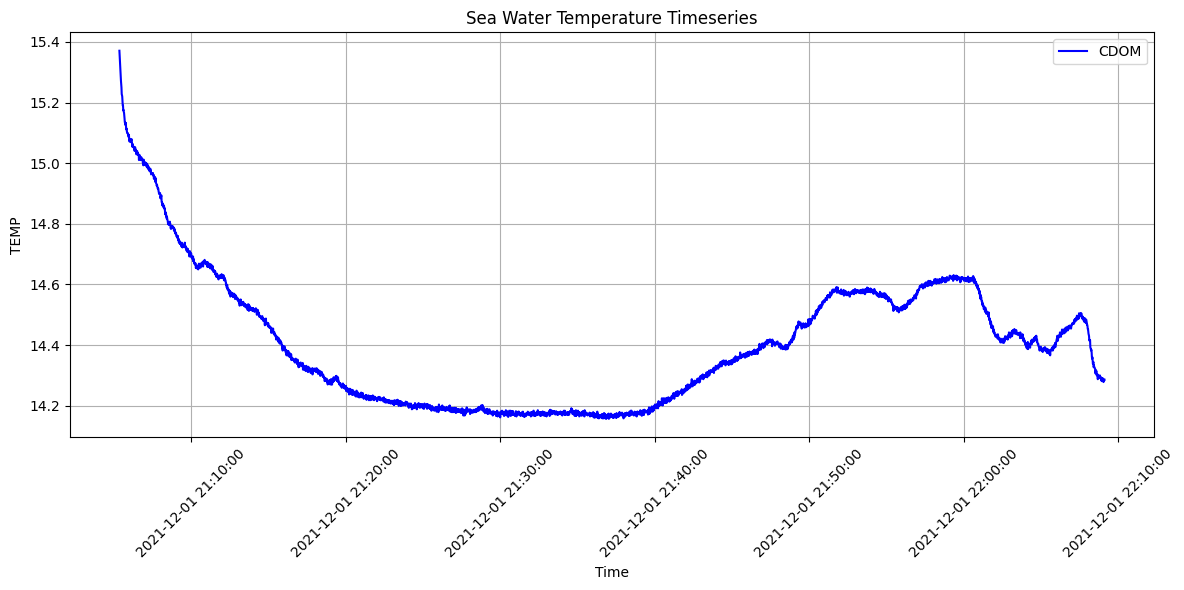

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

# Plot the time series
plt.plot(df['TIME'], df['TEMP'], label='CDOM', color='blue')

# Formatting the plot
plt.xlabel('Time')
plt.ylabel('TEMP')
plt.title('Sea Water Temperature Timeseries')
plt.grid(True)
plt.legend()

# Formatting the x-axis for date display
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

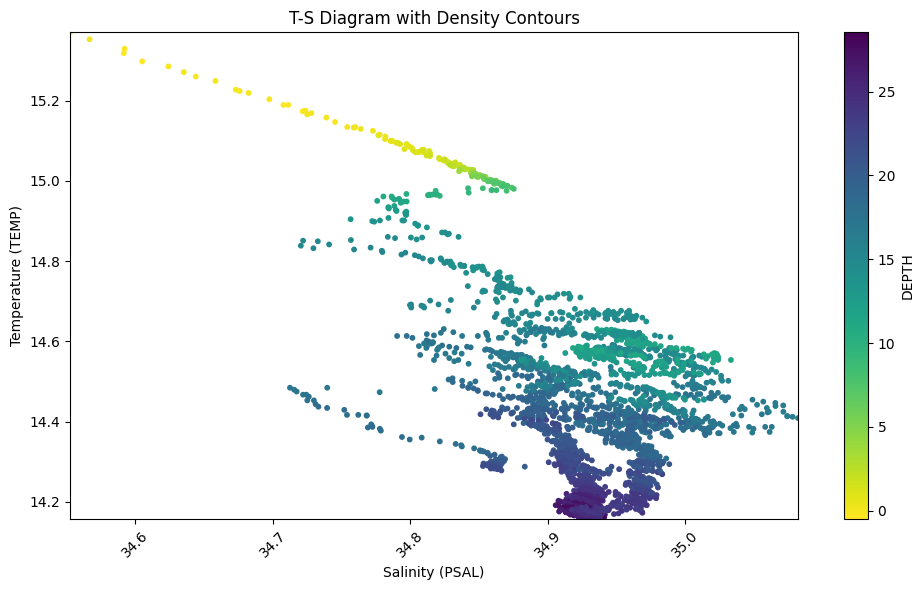

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import gsw  # TEOS-10 library


plot_ts_diagram(df)

## Create a TIME and scalar/number filter

In [16]:
expr_1 = pc.field('campaign_name') == "DiscoveryBay202112"
filter = expr_1

In [17]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23527 entries, 0 to 23526
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   filename       23527 non-null  object        
 1   TIME           23527 non-null  datetime64[ns]
 2   LATITUDE       23527 non-null  float64       
 3   LONGITUDE      23527 non-null  float64       
 4   DEPTH          23527 non-null  float64       
 5   PSAL           23527 non-null  float64       
 6   TEMP           23527 non-null  float64       
 7   OPBS           0 non-null      float32       
 8   CPHL           0 non-null      float32       
 9   CDOM           0 non-null      float32       
 10  campaign_name  23527 non-null  category      
 11  dive_name      23527 non-null  category      
 12  timestamp      23527 non-null  category      
 13  polygon        23527 non-null  category      
dtypes: category(4), datetime64[ns](1), float32(3), float64(5), object(1)
m

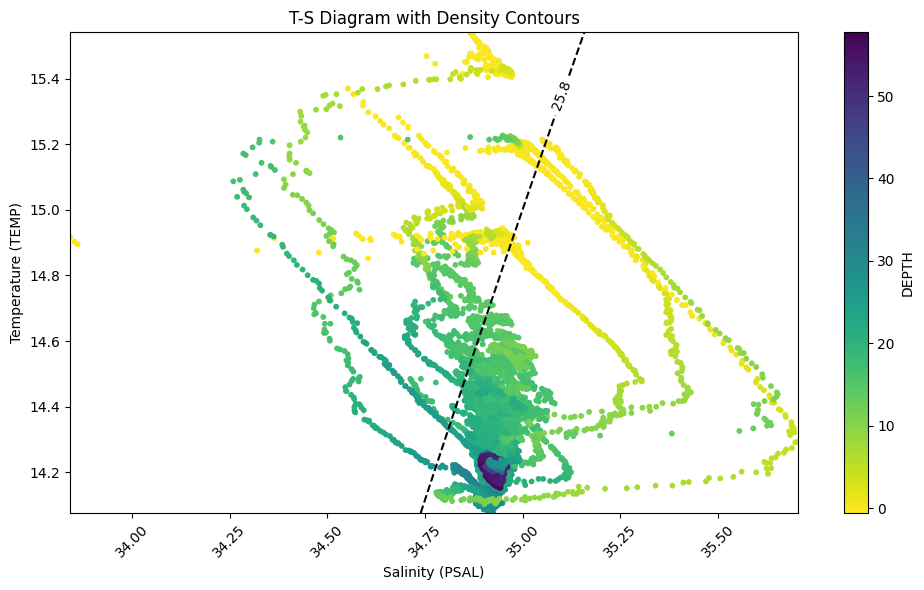

In [18]:
filtered_df = df[(df['PSAL'] >= 30)]

plot_ts_diagram(filtered_df)